In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.models.models import ClassTransformationReg

from scipy import stats

from catboost import CatBoostClassifier, CatBoostRegressor

seed = 42
pd.set_option('display.max_columns', None)
np.set_printoptions(4)

For in-depth explanations see: [uplift models, habr](https://habr.com/ru/company/ru_mts/blog/485980/)

In [2]:
train = pd.read_csv("train.csv")
train.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [5]:
train.describe()

,id,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,299999.500000,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,-1.659301,19.093492,-0.093886,-0.002533,-2.463280,13.161988,7.063375,6.858253,-0.020896,-0.985809,-1.114770,14.835209,-9.909231,0.002470,-0.002707,11.159296,0.024798,-0.978981,4.599121,-6.263516,0.000554,2.704003,0.027546,-6.514740,-0.005655,3.002134,5.325791,7.739900,-4.721989,-9.206852,2.728692,6.882868,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456,0.204190
std,173205.225094,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,199.625148,455.894665,11.295157,56.797326,39.922589,114.277207,77.628539,190.951808,11.476030,26.239683,72.371005,138.517373,160.879307,0.999777,1.000431,104.195126,28.332643,13.729246,142.981246,75.071084,1.000134,51.108902,107.851987,153.130771,6.964937,47.529482,70.700510,134.675174,131.789351,197.493595,39.501936,163.776538,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662,0.403109
min,0.000000,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,-2289.294108,-52.074964,-313.255431,-195.457350,-636.553079,-533.404670,-913.011610,-55.140610,-125.733156,-330.755792,-770.324798,-774.266979,-4.545333,-4.708793,-579.451426,-126.515623,-64.651485,-732.116727,-399.414460,-4.553086,-346.728398,-515.521884,-743.800243,-32.088261,-251.277376,-348.076864,-668.793144,-700.110808,-1016.301591,-179.589370,-810.842593,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323,0.000000
25%,149999.750000,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,-134.565241,-286.292508,-7.613948,-38.401625,-29.205585,-62.727814,-36.893267,-121.868113,-7.752689,-18.645383,-50.050451,-77.058591,-117.394644,-0.671963,-0.676781,-57.964784,-19.118055,-10.247693,-91.190920,-56.366783,-0.674265,-30.975631,-72.732677,-109.888686,-4.711524,-26.971012,-42.250017,-82.922581,-93.661192,-142.413854,-23.338528,-102.658380,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688,0.000000
50%,299999.500000,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,-1.628897,17.651122,-0.092166,-0.011893,-2.438805,13.426780,6.988854,6.639970,-0.030727,-1.007271,-1.084433,15.207025,-9.837197,0.001802,-0.003722,11.438983,0.023834,-0.946478,4.772537,-6.364402,-0.000372,2.732262,0.114877,-6.661874,-0.000436,2.966662,5.500324,7.516796,-4.835168,-9.003721,2.779691,7.190600,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895,0.000000
75%,449999.250000,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,130.948487,324.226048,7.409305,38.291691,24.248160,89.130548,50.993029,135.756702,7.731675,16.690977,47.694238,106.788310,97.891879,0.677217,0.671145,80.32798

In [7]:
train.conversion.value_counts(normalize=True)

0    0.79581
1    0.20419
Name: conversion, dtype: float64

In [8]:
train.treatment_group.value_counts(normalize=True)

treatment    0.500613
control      0.499387
Name: treatment_group, dtype: float64

In [9]:
train.groupby("treatment_group")["conversion"].mean()

treatment_group
control      0.179400
treatment    0.228919
Name: conversion, dtype: float64

In [14]:
conv_table = pd.pivot_table(train, values="id", index="treatment_group", columns="conversion", aggfunc="count")
stats.chi2_contingency(conv_table, correction=False)[1]  # p-value is less than 0.05 => there is significant difference

0.0

In [3]:
def evaluate(y_valid, uplift, treatment_valid, k=0.3):
    """
    https://www.kaggle.com/code/vanguarde/study-series-uplift-modeling
    k - top percent of observations sorted by uplift values
    """
    # by_group
    # Separately calculates conversions in top k observations in each group (control and treatment) 
    # sorted by uplift predictions. Then the difference between these conversions is calculated
    # overall
    #  the first k observations of all test data ordered by uplift prediction (overall both groups - control and treatment) 
    # and conversions in treatment and control groups calculated only on them. Then the difference between these conversions 
    # is calculated.
    upliftk = uplift_at_k(y_true=y_valid, uplift=uplift, treatment=treatment_valid, strategy='by_group', k=k)
    upliftk_all = uplift_at_k(y_true=y_valid, uplift=uplift, treatment=treatment_valid, strategy='overall', k=k)

    # Q_coef = (AUC_model - AUC_random) / (AUC_perfect - AUC_random)
    qini_coef = qini_auc_score(y_true=y_valid, uplift=uplift, treatment=treatment_valid)
    
    # AUC 
    uplift_auc = uplift_auc_score(y_true=y_valid, uplift=uplift, treatment=treatment_valid)

    wau = weighted_average_uplift(y_true=y_valid, uplift=uplift, treatment=treatment_valid, strategy='by_group')
    wau_all = weighted_average_uplift(y_true=y_valid, uplift=uplift, treatment=treatment_valid)

    print(f'uplift at top {int(k*100)}% by group: {upliftk:.2f} by overall: {upliftk_all:.2f}\n',
          f'Weighted average uplift by group: {wau:.2f} by overall: {wau_all:.2f}\n',
          f'AUUC by group: {uplift_auc:.2f}\n',
          f'AUQC by group: {qini_coef:.2f}\n')
    return {f'uplift@{int(k*100)}': upliftk, f'uplift@{int(k*100)}_all': upliftk_all, 'AUQC': qini_coef, 'AUUC': uplift_auc, 
            'WAU': wau, 'WAU_all': wau_all}

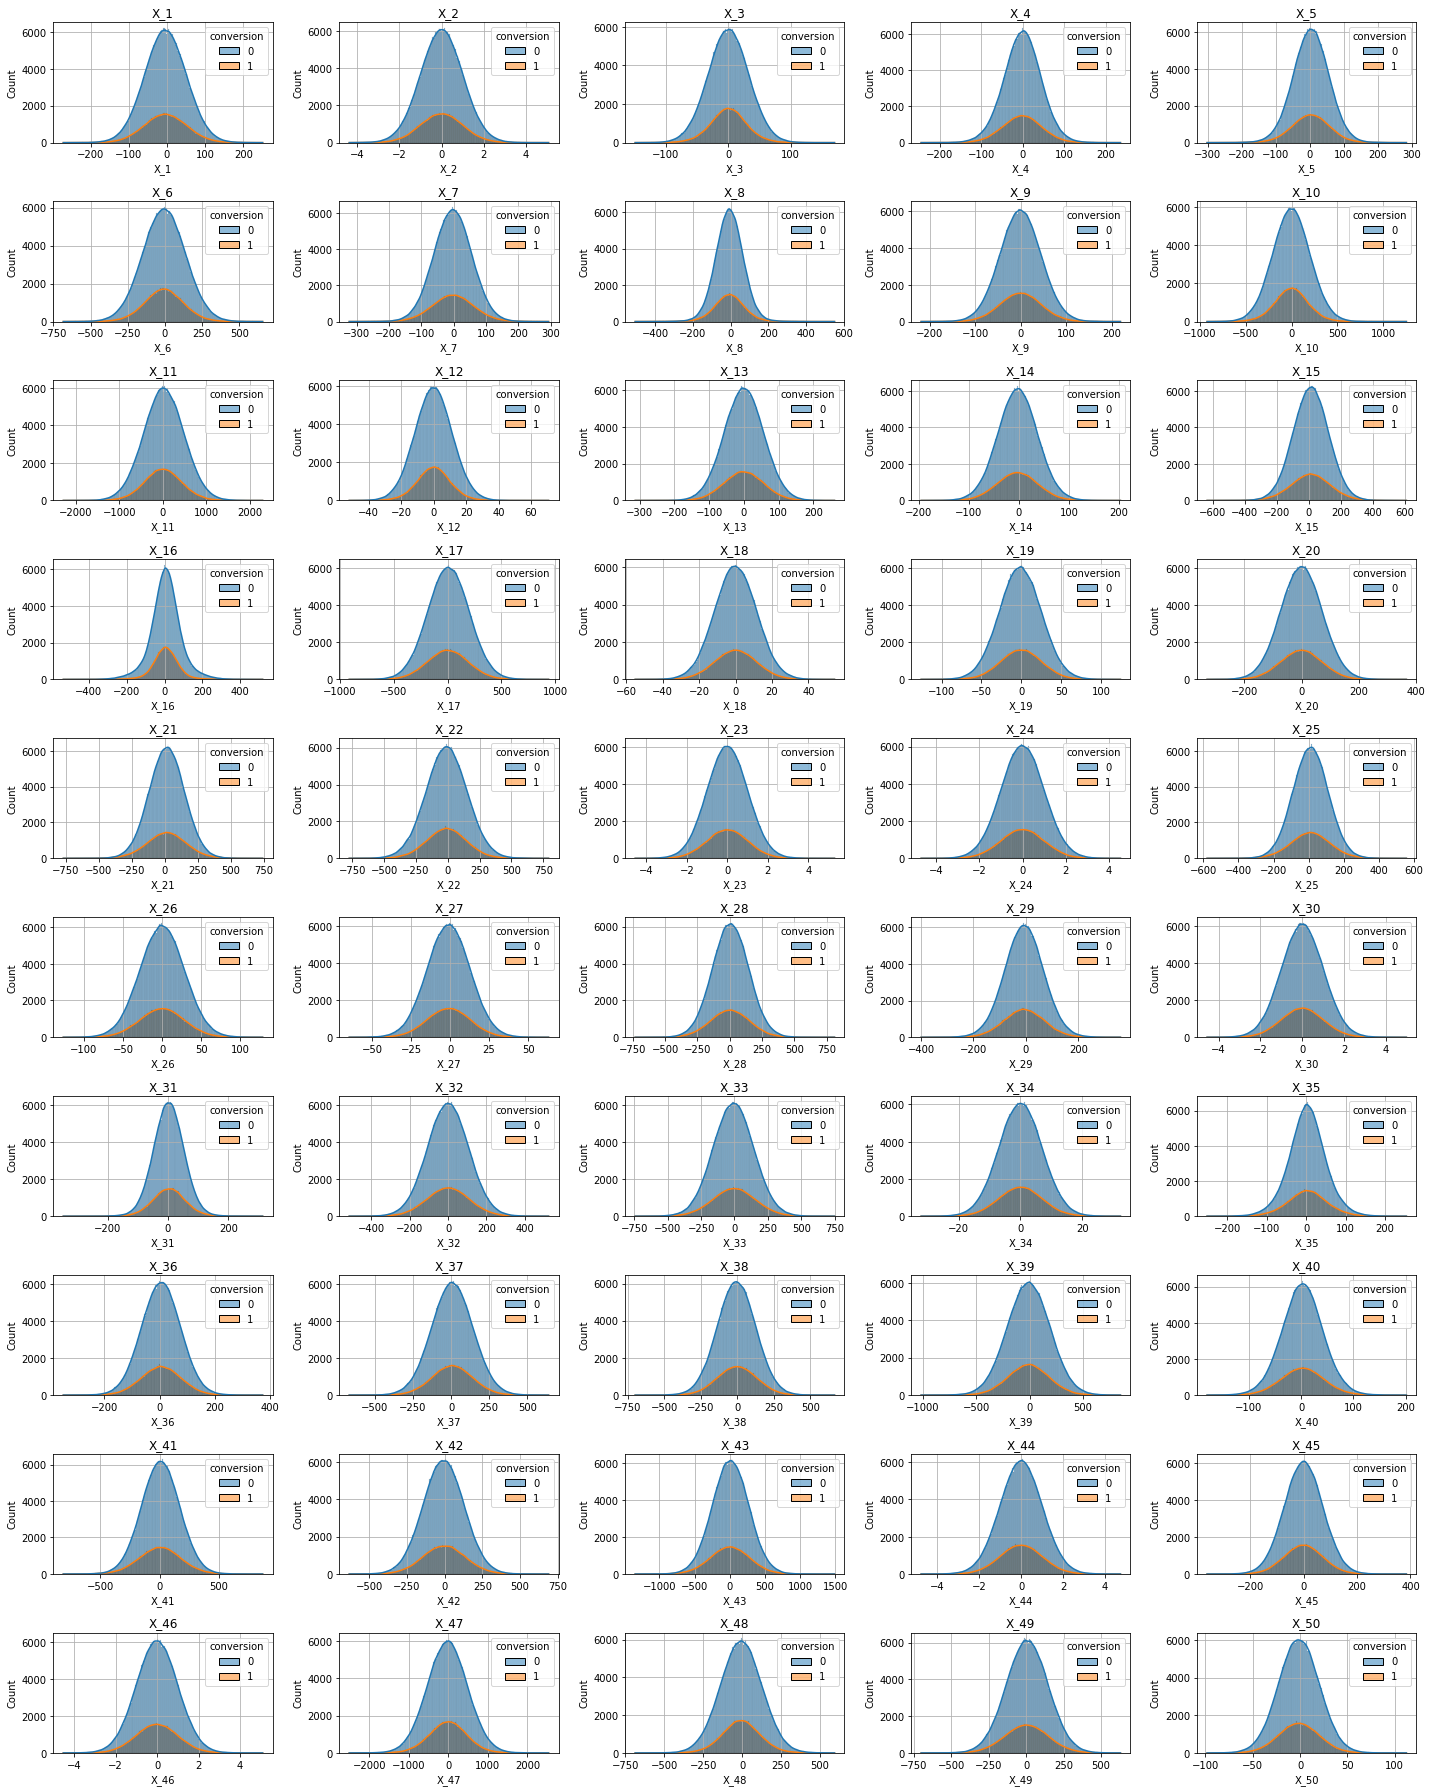

In [21]:
# data is normally distributes, no skewness or kurtosis is observed
plt.figure(figsize=(20, 25))
for i, column in enumerate(train.select_dtypes("float").columns, 1):
    plt.subplot(10, 5, i)
    plt.title(f"{column}")
    sns.histplot(x=column, data=train, hue="conversion", kde=True)
    plt.grid(axis="both")
plt.tight_layout()
plt.show()

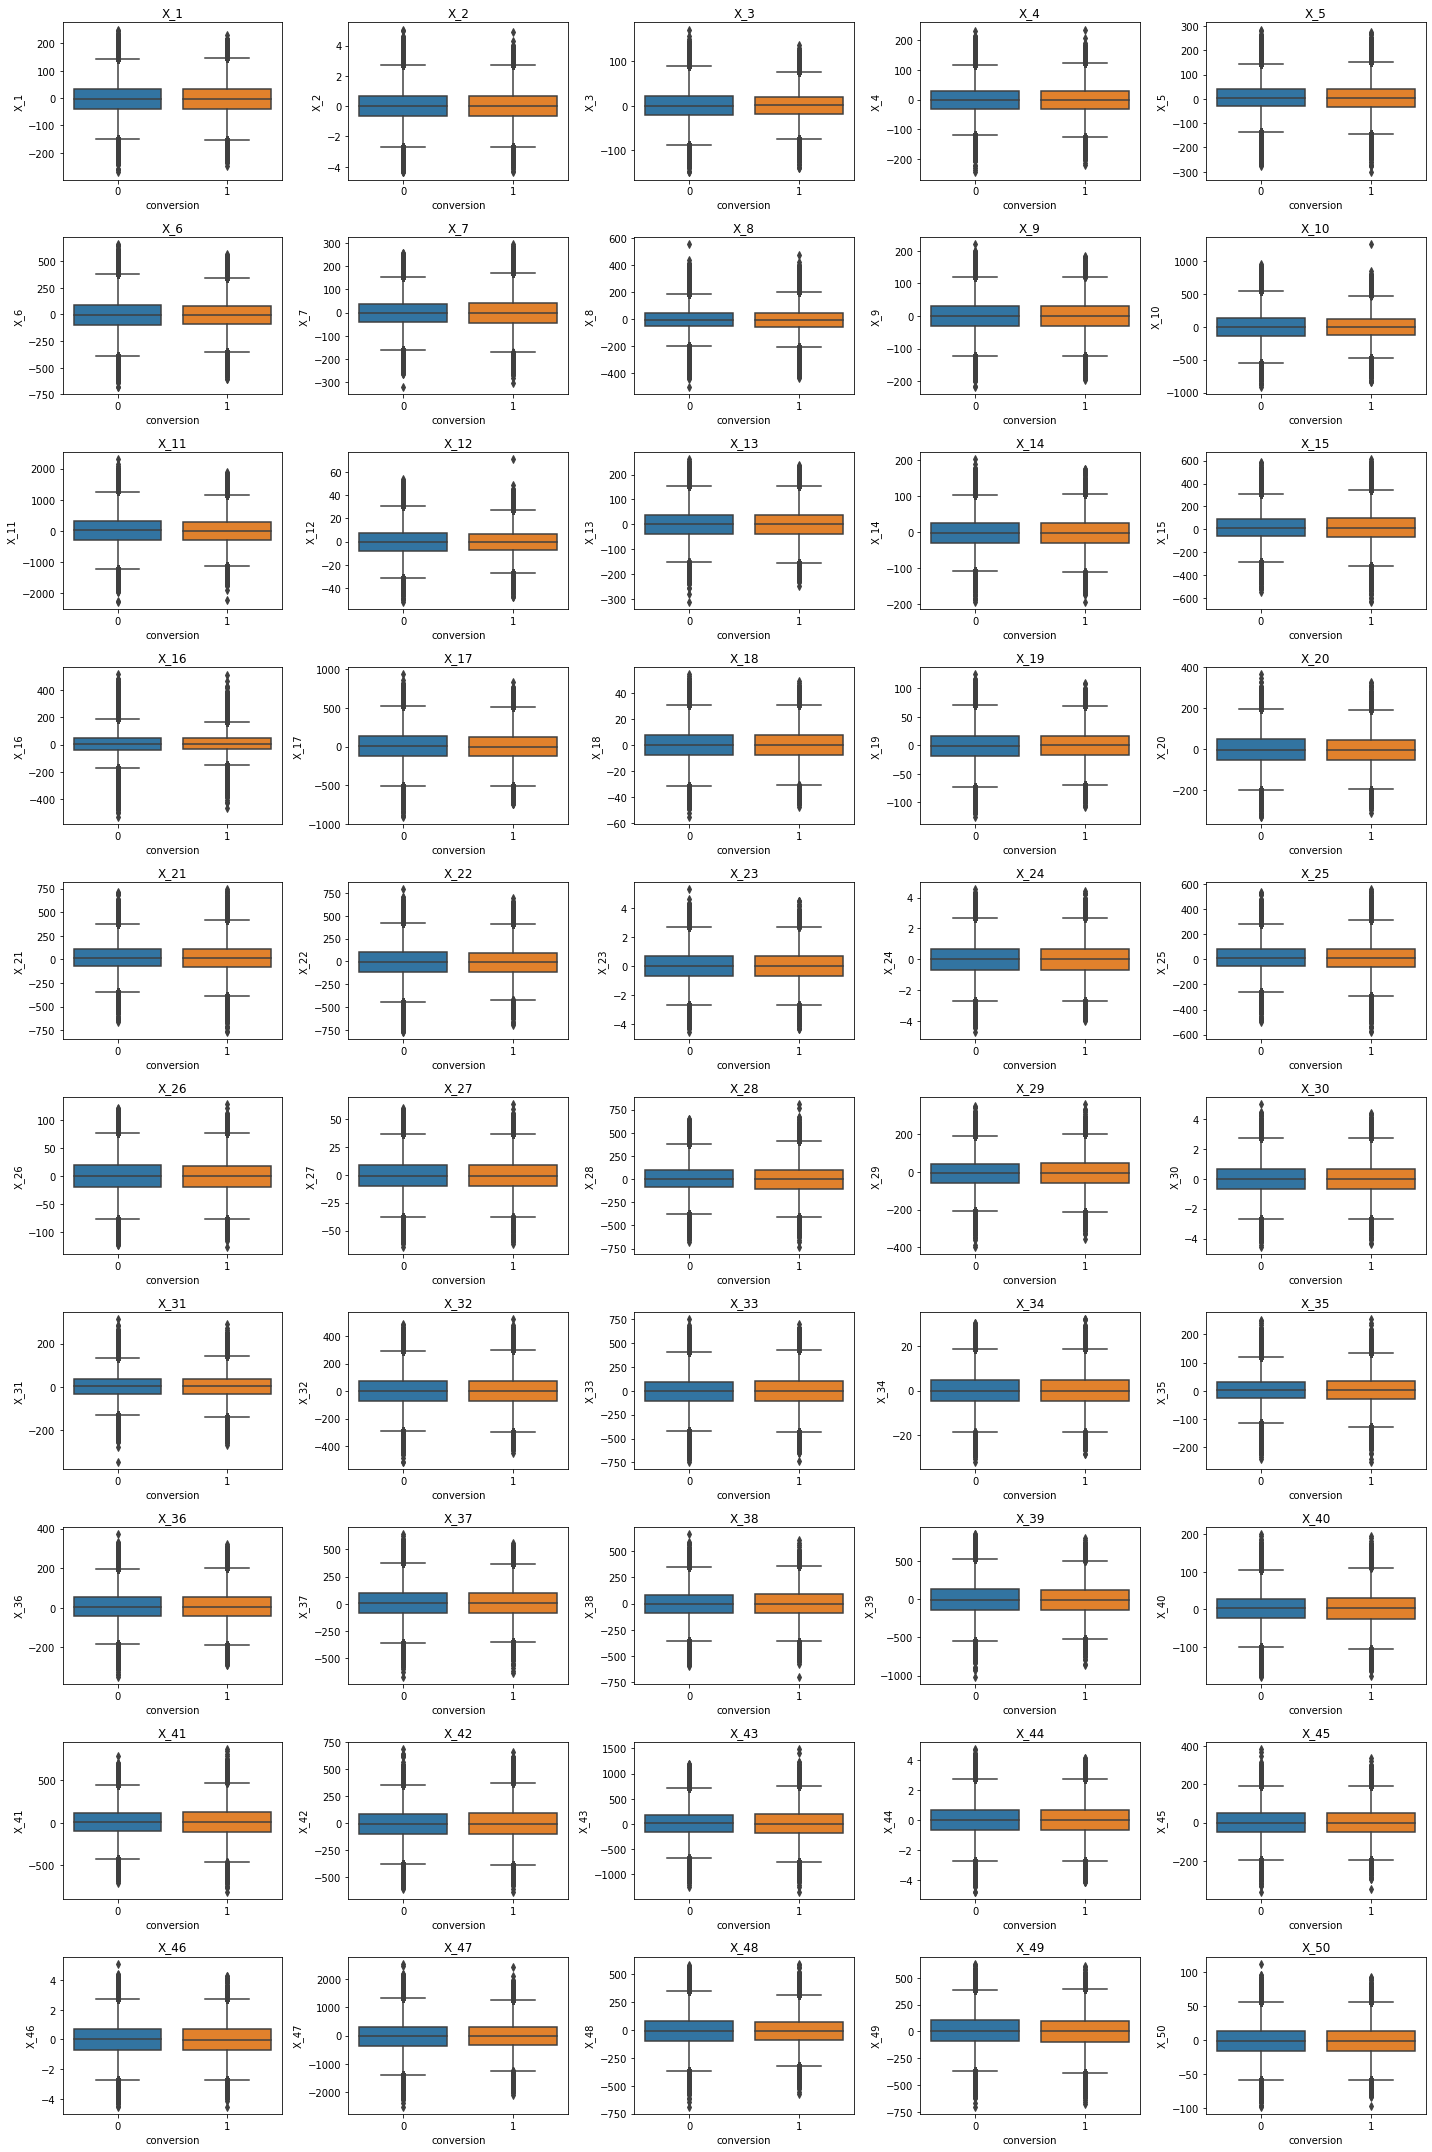

In [31]:
# boxplots: visually no significant difference observed in statistics
plt.figure(figsize=(20, 30))
for i, column in enumerate(train.select_dtypes("float").columns, 1):
    plt.subplot(10, 5, i)
    plt.title(f"{column}")
    sns.boxplot(x="conversion", y=column, data=train)
plt.tight_layout()
plt.show()

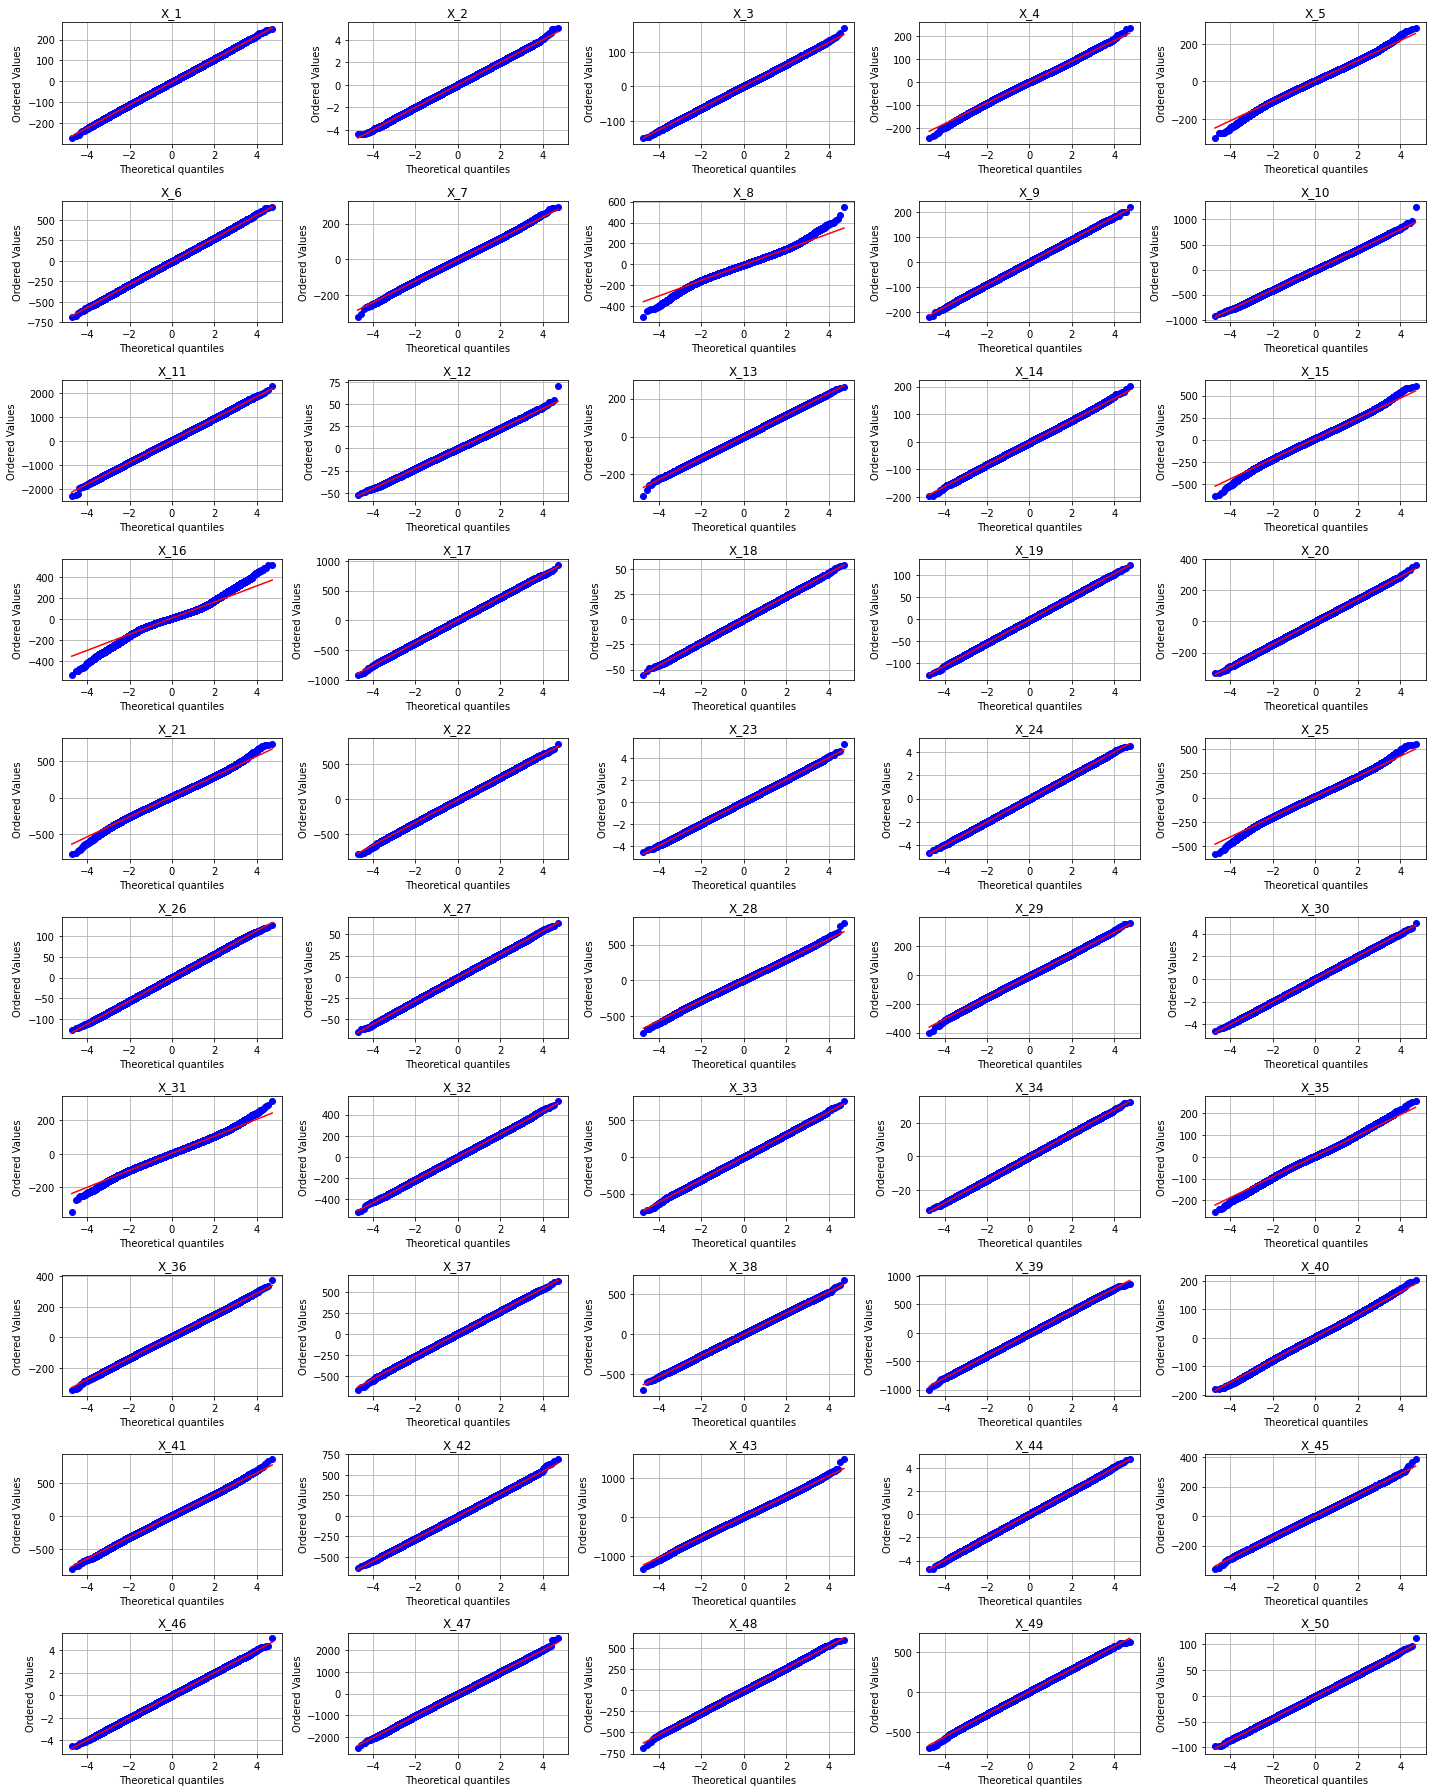

In [38]:
# plot qqplots: feature z-scored distribution quantiles against theretic quantiles of normal distribution
rows, cols = 10, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 25))

float_columns = train.select_dtypes("float").columns

feat_num = 0
for i in range(rows):
    for j in range(cols):
        stats.probplot(train[float_columns[feat_num]], plot=ax[i, j])
        ax[i, j].set_title(f"{float_columns[feat_num]}")
        ax[i, j].grid(axis="both")
        feat_num += 1
plt.tight_layout()
plt.show()

In [44]:
# X_16 has peaky shape, H_0 - the data is normally distributed

stats.shapiro(np.log1p(train["X_16"]))[1]

1.0

In [71]:
# train["X_16_log"] = np.log1p(train["X_16"])

In [4]:
train.set_index("id", inplace=True)

In [5]:
# split into features, conversion, treatment
# treatment = control (no offer to client), treat (offer to client)
train["treatment_group"] = train["treatment_group"].map({"control": 0, "treatment": 1})

X = train.iloc[:, 1:-1]
treatment = train["treatment_group"]
y = train["conversion"]

x_train, x_valid, y_train, y_valid, treatment_train, treatment_valid = train_test_split(X, y, treatment, test_size=100_000, 
                                                                                        stratify=treatment, random_state=seed)
print(f"Train size: {len(y_train)}, validation size: {len(y_valid)}")

Train size: 500000, validation size: 100000


In [6]:
# baseline solomodel

cb_params = {
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "max_bin": 32,
            "silent": True,
            "depth": 16,  # 16 if Lossguide, 6 SymmetricTree
            "l2_leaf_reg": 30,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "auto_class_weights": "SqrtBalanced",
            "subsample": 0.8, 
            "grow_policy": "Lossguide",  # SymmetricTree
            "boosting_type": "Plain",  # Ordered
            "score_function": "L2",  # L2 for Lossguide (leafwise construction)
            "bootstrap_type": "MVS",  # Bayesian
            "bagging_temperature": 1, 
            "colsample_bylevel": 0.9,
            "min_data_in_leaf": 200,  # Lossguide
            "max_leaves": 128,  # Lossguide
        }

cat = CatBoostClassifier(**cb_params)

In [7]:
%%time
baseline = SoloModel(cat)
baseline = baseline.fit(x_train, y_train, treatment_train)

CPU times: total: 28min 55s
Wall time: 2min 24s


In [8]:
uplift = baseline.predict(x_valid)

In [9]:
baseline_eval = evaluate(y_valid, uplift, treatment_valid)

uplift at top 30% by group: 0.23 by overall: 0.23
 Weighted average uplift by group: 0.06 by overall: 0.05
 AUUC by group: 0.17
 AUQC by group: 0.24



**Two dependent models**

In [10]:
%%time
# two models

indep_models = TwoModels(estimator_trmnt=CatBoostClassifier(**cb_params), 
                         estimator_ctrl=CatBoostClassifier(**cb_params), 
                         method='ddr_control')  # train control first

indep_models = indep_models.fit(x_train, y_train, treatment_train)

CPU times: total: 33min 22s
Wall time: 2min 29s


In [11]:
uplift_tm = indep_models.predict(x_valid)

In [12]:
tm_eval = evaluate(y_valid, uplift_tm, treatment_valid)

uplift at top 30% by group: 0.22 by overall: 0.22
 Weighted average uplift by group: 0.06 by overall: 0.06
 AUUC by group: 0.16
 AUQC by group: 0.24



In [13]:
%%time
# two models

indep_models = TwoModels(estimator_trmnt=CatBoostClassifier(**cb_params), 
                         estimator_ctrl=CatBoostClassifier(**cb_params), 
                         method='ddr_treatment')  # train treatment first

indep_models = indep_models.fit(x_train, y_train, treatment_train)

CPU times: total: 37min 44s
Wall time: 2min 52s


In [14]:
uplift_ttm = indep_models.predict(x_valid)

In [15]:
ttm_eval = evaluate(y_valid, uplift_ttm, treatment_valid)

uplift at top 30% by group: 0.22 by overall: 0.22
 Weighted average uplift by group: 0.06 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



**Target transformation**

$Z_i = Y_i\cdot W_i + (1 - Y_i)\cdot (1 - W_i)$

где $Z_i$ — новая целевая переменная $i$-ого клиента
$Y_i$ — целевая переменная $i$-ого клиента
$W_i = \{0, 1\}$ — бинарный флаг коммуникации: при $W_i = 1$ — $i$-й клиент попал в целевую (treatment) группу, где была коммуникация; при $W_i = 0$ — $i$-й клиент попал в контрольную (control) группу, где не было коммуникации.

In [17]:
%%time
cls_model = ClassTransformation(estimator=CatBoostClassifier(**cb_params)).fit(x_train, y_train, treatment_train)

CPU times: total: 26min 20s
Wall time: 2min 17s


In [18]:
uplift_cls = cls_model.predict(x_valid)

In [19]:
cls_eval = evaluate(y_valid, uplift_cls, treatment_valid)

uplift at top 30% by group: 0.22 by overall: 0.22
 Weighted average uplift by group: 0.06 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



$Z_i = Y_i\frac{W_i - p}{p\cdot (1 - p)}$

Где $ Z_i $ — новая целевая переменная для $ i $-ого клиента
$ W_i $ — флаг коммуникации для $ i $-ого клиента
$ p $ — propensity score или вероятность отнесения к целевой группе: $ p = P(W_i = 1 | X_i = x) $

In [22]:
rg_params = {
            "iterations": 1000,
            "learning_rate": 0.01,
            "loss_function": "RMSE",
            "task_type": "CPU",
            "max_bin": 32,
            "silent": True,
            "depth": 16,
            "l2_leaf_reg": 30,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "subsample": 0.8, 
            "grow_policy": "Lossguide",
            "boosting_type": "Plain",
            "score_function": "L2",
            "bootstrap_type": "MVS",
            "bagging_temperature": 1, 
            "colsample_bylevel": 0.9,
            "min_data_in_leaf": 200, 
            "max_leaves": 128,
        }

In [23]:
%%time
cls_mse_model = ClassTransformationReg(estimator=CatBoostRegressor(**rg_params),
                                       propensity_estimator=CatBoostClassifier(**cb_params))

cls_mse_model = cls_mse_model.fit(x_train, y_train, treatment_train)

CPU times: total: 42min 17s
Wall time: 3min 57s


In [24]:
uplift_cls_mse = cls_mse_model.predict(x_valid)

In [25]:
cls_mse_eval = evaluate(y_valid, uplift_cls_mse, treatment_valid)

uplift at top 30% by group: 0.22 by overall: 0.22
 Weighted average uplift by group: 0.06 by overall: 0.05
 AUUC by group: 0.16
 AUQC by group: 0.24



**Conclusions**

In [28]:
results = [baseline_eval, tm_eval, ttm_eval, cls_eval, cls_mse_eval]
compare = pd.DataFrame.from_records(results, index=["Solo", "Two_control", "Two_treat", "Target_tr", "Target_MSE"])

In [30]:
compare.sort_values("AUQC")

,uplift@30,uplift@30_all,AUQC,AUUC,WAU,WAU_all
Target_tr,0.223549,0.224067,0.235249,0.162868,0.055099,0.054856
Target_MSE,0.224609,0.224887,0.235597,0.163138,0.055098,0.054779
Two_control,0.219765,0.220069,0.236095,0.163466,0.055100,0.055137
Two_treat,0.221060,0.221504,0.237429,0.164615,0.055096,0.054677
Solo,0.227713,0.228104,0.243708,0.168807,0.055098,0.054985


#### CatBoost Appendix

MVS (https://catboost.ai/en/docs/concepts/algorithm-main-stages_bootstrap-options#mvs) - sampling instances for the next iteration. Scoring of a split candidate is based on estimating of the expected gradient in each leaf (provided by this candidate).

MVS samples the subsample examples $i$ such that the largest values of $|g_i|$ are taken with probability $p_{i}=1$ and each other example $i$ is sampled with probability $\frac{|g_i|}{\mu}$, where $\mu$ is the threshold for considering the gradient to be large if the value is exceeded.

Then, the estimate of the expected gradient is calculated:

$\hat{E}g = \frac{\Sigma_{i: all\ sampled\ examples}\frac{g_i}{p_i}}{\Sigma_{i: all\ sampled\ examples}\frac{1}{p_i}}$, where

* The numerator is the unbiased estimator of the sum of gradients.
* The denominator is the unbiased estimator of the number of training samples.

This algorithm provides the minimum variance estimation of the L2 split score for a given expected number of sampled examples.

Estimated score for given candidate: $S = \Sigma_{i: all\ training\ samples}p_i$

It is important to reduce the variance of both the numerator and the denominator

MVS decreases the number of sample instances in the split search by maximizing the estimation accuracy of split scoring.

So, simply saying, the algorithm samples low-gradient examples (with calculated probability) so that the scoring function is maximized, unlike GOSS from lgmb samples such examples with fixed probability. Also MVS (minimal variance sampling) provides lower variance of $\hat{E}g$ than GOSS.